In [ ]:

import openai
import pandas as pd
import json
import time
import matplotlib.pyplot as plt

openai.api_key = "your_api_key"

In [15]:
# load csv
input_csv = "House Cleaning Reviews.csv"
df = pd.read_csv(input_csv)
for col in ["Client", "Source", "Date", "Review"]:
    if col not in df.columns:
        raise ValueError(f"{col} missing")
df.dropna(subset=["Review"], inplace=True)
df.reset_index(drop=True, inplace=True)

# prompt
prompt_json = """
you are an assistant that analyzes customer reviews about a house cleaning service.

extract only valid json with these arrays from the review text:

{
  "positive_categories": [],
  "positive_subcategories": [],
  "negative_categories": [],
  "negative_subcategories": []
}

allowed categories/subcategories:

positive categories:
quality of cleaning: detailed cleaning, thoroughness, attention to detail, cleanliness, spotless results
professionalism/service: friendliness, communication, responsiveness, customer service, booking options, payment options
efficiency/speed: quick service, efficient work, punctuality
value/price: reasonable pricing, good value for money
specific tasks: deep cleaning, move-in/move-out cleaning, organization, special requests, nature-friendly chemicals
trustworthiness: honesty, reliability, favorite worker

negative categories:
quality of cleaning: missed spots, inconsistent cleaning, poor attention to detail, damage to property
professionalism/service: unprofessional behavior, poor communication, lack of responsiveness
efficiency/speed: slow service, incomplete work, late arrival
value/price: overpriced, hidden fees
specific issues: damage to items, issues with specific areas of the house
trustworthiness: theft, dishonesty

review:
"""

def analyze_review_json(review):
    full = prompt_json + review.strip()
    resp = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user","content":full}],
        temperature=0,
        max_tokens=300
    )
    text = resp.choices[0].message.content.strip()
    if text.startswith("```"):
        text = text.strip("`").replace("json","").strip()
    data = json.loads(text)
    pc = ";".join(data.get("positive_categories", []))
    ps = ";".join(data.get("positive_subcategories", []))
    nc = ";".join(data.get("negative_categories", []))
    ns = ";".join(data.get("negative_subcategories", []))
    return pc, ps, nc, ns

# extract json for each review
results = []
for _, row in df.iterrows():
    pc, ps, nc, ns = analyze_review_json(row["Review"])
    results.append({
        "Client": row["Client"],
        "Source": row["Source"],
        "Date": row["Date"],
        "Review": row["Review"],
        "Positive Category": pc,
        "Positive Subcategory": ps,
        "Negative Category": nc,
        "Negative Subcategory": ns
    })

out_df = pd.DataFrame(results)
out_df.to_csv("reviews_processed.csv", index=False)

# aggregate counts
pos = out_df["Positive Category"].str.split(";").explode().dropna()
neg = out_df["Negative Category"].str.split(";").explode().dropna()
pos_counts = pos[pos != ""].value_counts().to_dict()
neg_counts = neg[neg != ""].value_counts().to_dict()

# summary request
summary_prompt = f"""
here are aggregated counts

positive: {pos_counts}
negative: {neg_counts}

provide a concise summary of top features and pain points with frequency, brief explanation, and one representative quote each
"""
resp = openai.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role":"user","content":summary_prompt}],
    temperature=0,
    max_tokens=400
)
print(resp.choices[0].message.content.strip())

### Summary of Top Features and Pain Points

#### Positive Features

1. **Quality of Cleaning (122 mentions)**
   - **Explanation:** Customers consistently praise the thoroughness and effectiveness of the cleaning services provided.
   - **Quote:** "The attention to detail in the cleaning was outstanding; my home has never looked better!"

2. **Professionalism/Service (113 mentions)**
   - **Explanation:** Many reviews highlight the courteous and respectful demeanor of the staff, contributing to a positive customer experience.
   - **Quote:** "The team was not only friendly but also very professional throughout the entire process."

3. **Efficiency/Speed (52 mentions)**
   - **Explanation:** Clients appreciate the quick turnaround and timely service, which enhances overall satisfaction.
   - **Quote:** "They completed the job much faster than I expected without compromising on quality."

#### Negative Pain Points

1. **Professionalism/Service (32 mentions)**
   - **Explanation:** Some 

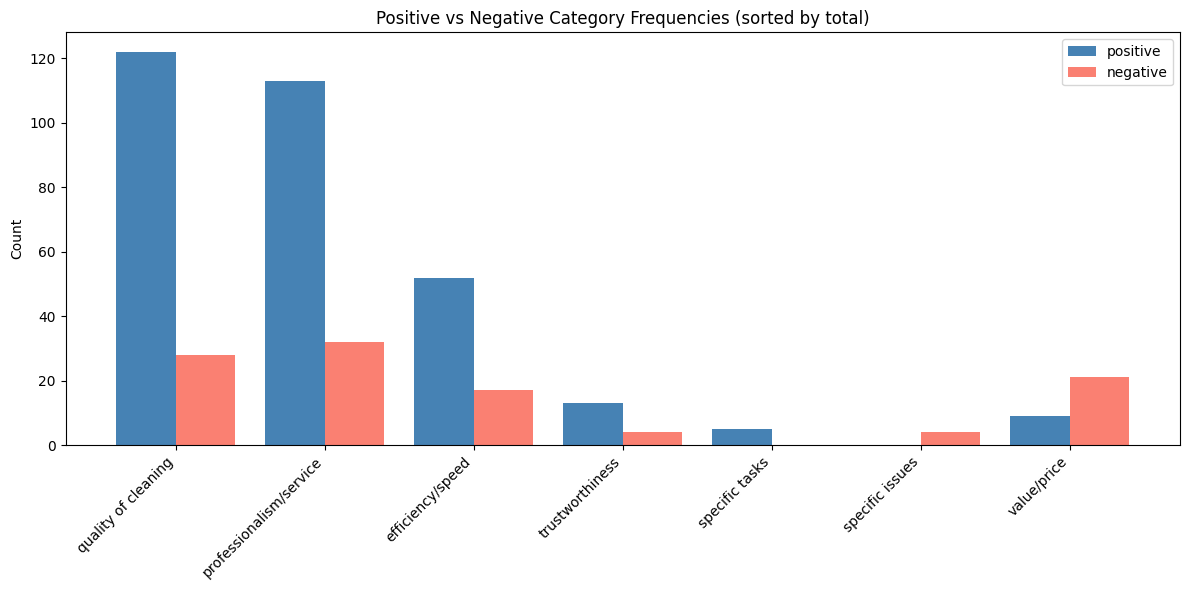

In [20]:
# Compute combined counts and sort categories by total mentions
cats = sorted(set(pos_counts.index) | set(neg_counts.index),
              key=lambda c: pos_counts.get(c, 0) + neg_counts.get(c, 0),
              reverse=True)

pos_vals = [pos_counts.get(c, 0) for c in cats]
neg_vals = [-neg_counts.get(c, 0) for c in cats]

x = range(len(cats))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], pos_vals, width, color='steelblue', label='positive')
plt.bar([i + width/2 for i in x], neg_vals, width, color='salmon', label='negative')
plt.xticks(x, cats, rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Positive vs Negative Category Frequencies (sorted by total)')
plt.legend()
plt.tight_layout()
plt.show()